# California Housing Prices

In [152]:
import os
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted

warnings.filterwarnings('ignore')

In [153]:
PATH = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(PATH)
df.iloc[1000, 9] = np.nan

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20639 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [155]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [156]:
df['ocean_proximity'] = pd.Categorical(df.ocean_proximity)

In [157]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [158]:
df.ocean_proximity.value_counts(dropna=False)

<1H OCEAN     9136
INLAND        6550
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
NaN              1
Name: ocean_proximity, dtype: int64

I will drop the rows with NaN and 'ISLAND' as they are too rare.

In [159]:
df = df.dropna(subset=['ocean_proximity'])
df = df.loc[df.ocean_proximity!='ISLAND']

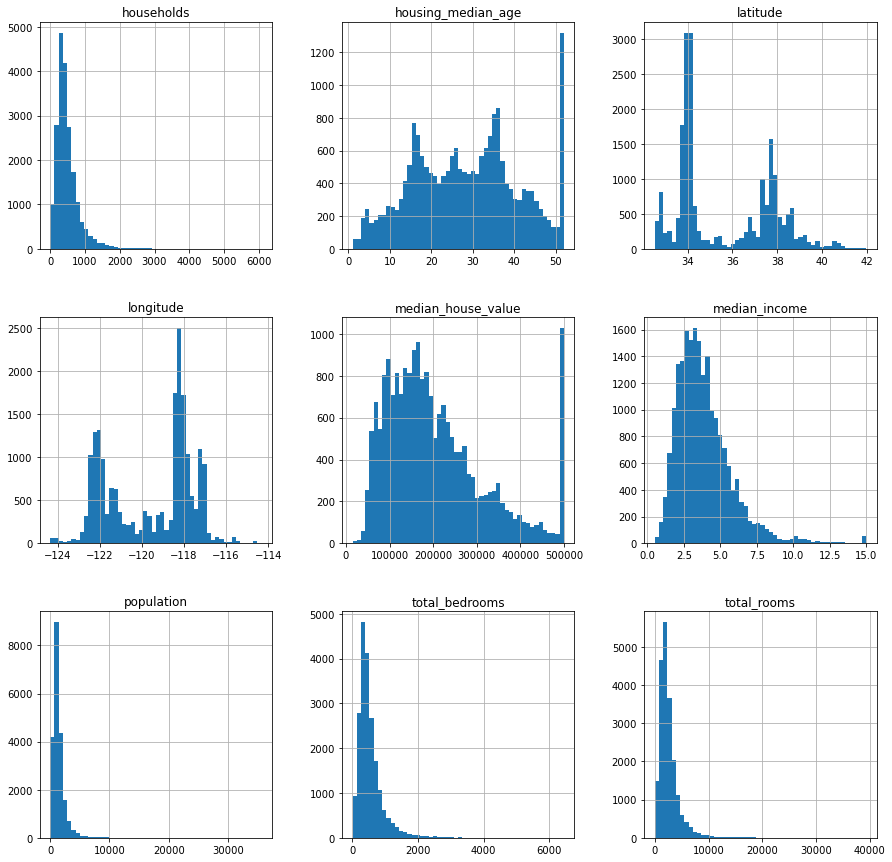

In [160]:
df.hist(bins=50, figsize=(15,15));

Dropping outliers:

In [161]:
df = df.loc[df.median_house_value<=500000]
df = df.loc[df.housing_median_age<52]

In [162]:
df.shape

(18569, 10)

In [163]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

X_train = train_df.drop(['median_house_value'], axis=1).copy()
y_train = train_df['median_house_value'].values

X_test = test_df.drop(['median_house_value'], axis=1).copy()
y_test = test_df['median_house_value'].values

In [166]:
def plot_corr_map(data, center=None):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = data.corr()
    hm = sns.heatmap(round(corr, 2),
                     annot=True,
                     ax=ax,
                     cmap="coolwarm",
                     fmt='.2f',
                     linewidths=.05,
                     center=center)
    f.subplots_adjust(top=0.93)
    t = f.suptitle('User Data Correlation Heatmap', fontsize=16)
    return f

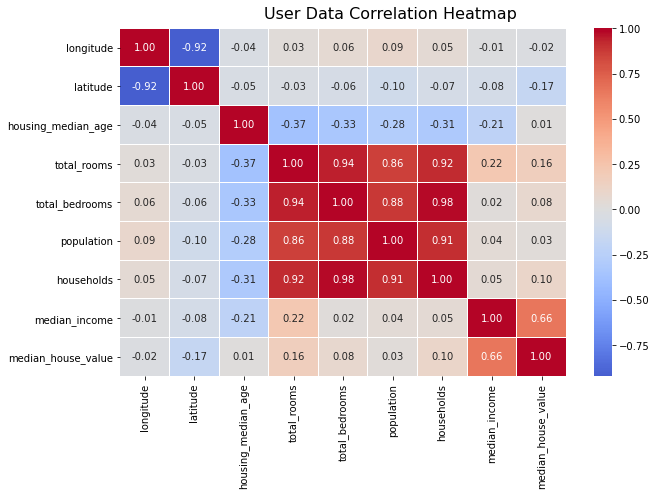

In [167]:
fig1 = plot_corr_map(train_df, center=0)

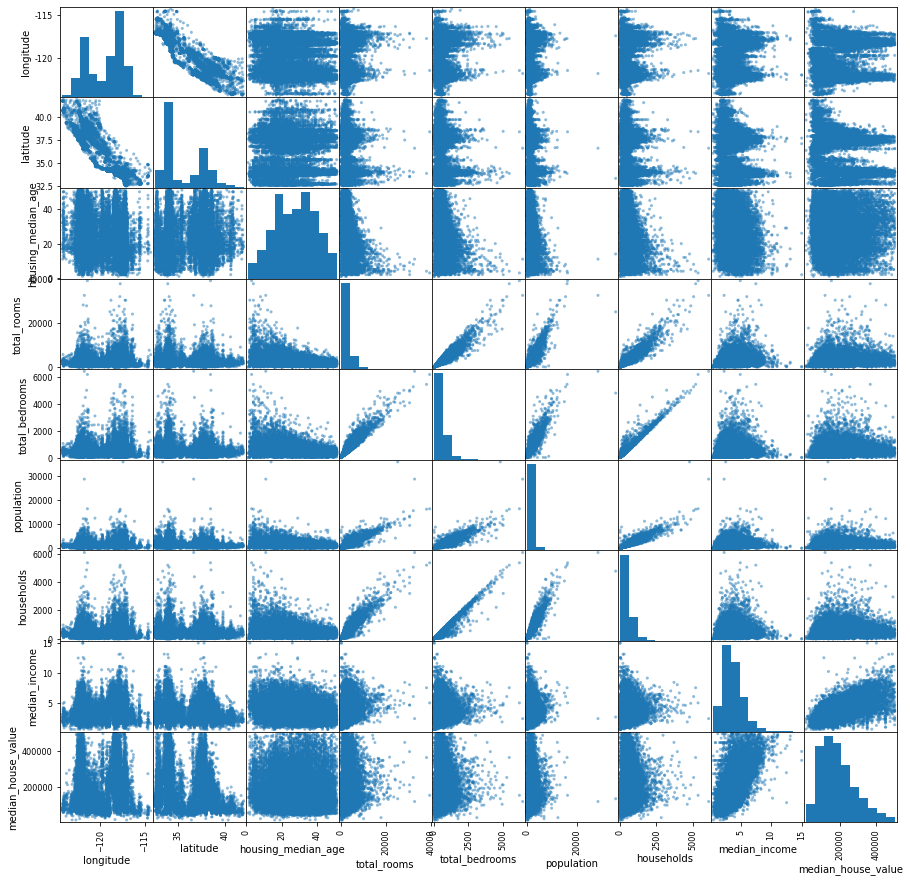

In [84]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, figsize=(15, 15));

General ->
* remove heavily correlated features or create features combining them

Numerical features ->
* impute median value for missing
* power transform features with standardization

Caetgorical features (ocean proximity) ->
* One hot encoder
* Standard scale

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18569 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           18569 non-null  float64 
 1   latitude            18569 non-null  float64 
 2   housing_median_age  18569 non-null  float64 
 3   total_rooms         18569 non-null  float64 
 4   total_bedrooms      18376 non-null  float64 
 5   population          18569 non-null  float64 
 6   households          18569 non-null  float64 
 7   median_income       18569 non-null  float64 
 8   median_house_value  18569 non-null  float64 
 9   ocean_proximity     18569 non-null  category
dtypes: category(1), float64(9)
memory usage: 2.1 MB


I will impute missing value for total bedrooms

In [253]:
rooms_idx, bedrooms_idx, pop_idx, households_idx = 3, 4, 5, 6

class AddFeatures(BaseEstimator, TransformerMixin):
    '''Create custom features'''
    def __init__(self, pop_per_household=True):
        self.pop_per_household = pop_per_household
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
        if self.pop_per_household:
            pop_per_household = X[:, pop_idx] / X[:, households_idx]
            return np.c_[X, rooms_per_household, bedrooms_per_room, pop_per_household]
        else:
            return np.c_[X, rooms_per_household, bedrooms_per_room]

In [132]:
class DropFeatures(BaseEstimator, TransformerMixin):
    '''Drop features by specifying which ones to drop'''
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.features_to_drop:
            X_r = X.copy()
            X_r = X_r.drop(self.features_to_drop, axis=1)
            self.feature_mask = ~X.columns.isin(self.features_to_drop)
            return X_r
        else:
            return X

In [133]:
class RegressorSelector(BaseEstimator):
    '''Choose model for regression'''
    def __init__(self, estimator = LinearRegression()):
        self.estimator = estimator

    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        check_is_fitted(self.estimator)
        return self.estimator.predict(X)

In [118]:
def cv_score_statistics(estimator, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1):
    scores = cross_val_score(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print('All scores:\n', np.sort(scores), '\n')
    print('Mean:', np.round(np.mean(scores), 3))
    print('SD:', np.round(np.std(scores), 3))

In [254]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('featureAdder', AddFeatures()),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('fs', RFE(estimator=RandomForestRegressor(), n_features_to_select=11))
])

In [255]:
cat_features = ['ocean_proximity']

In [256]:
pipeline = Pipeline(steps=[
    ('process', ColumnTransformer(transformers=[
        ('numProcess', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('catProcess', OneHotEncoder(drop='first'), cat_features)
    ])),
    ('regress', RegressorSelector())
])

**Baseline**

In [181]:
cv_score_statistics(pipeline, X_train, y_train)

All scores:
 [-61882.81795295 -59820.89600244 -58958.30570503 -58753.26131117
 -58201.24950178] 

Mean: -59523.306
SD: 1289.642


In [239]:
params = [
    {
        'process__numProcess__fs__n_features_to_select': [8, 9, 10, 11],
        'regress__estimator': [LinearRegression(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), SVR()]
    }
]
grid = GridSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=0,
                    n_jobs=-1,
                    scoring='neg_root_mean_squared_error'
                   )
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameters: {'process__numProcess__fs__n_features_to_select': 11, 'regress__estimator': RandomForestRegressor()}
Best score: -47690.93543090538


In [240]:
cv_score_statistics(grid.best_estimator_, X_train, y_train)

All scores:
 [-52390.80568243 -51143.59119692 -46124.80615973 -44916.29763389
 -44269.11076929] 

Mean: -47768.922
SD: 3341.84


In [258]:
params = [
    {
        'regress__estimator': [RandomForestRegressor()],
        'regress__estimator__n_estimators': [10, 50, 100, 200],
        'regress__estimator__min_samples_leaf': [3],
        'regress__estimator__max_features': [6, 8, 9, 10],
    }
]
grid = GridSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=0,
                    n_jobs=-1,
                    scoring='neg_root_mean_squared_error'
                   )
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameters: {'regress__estimator': RandomForestRegressor(max_features=6, min_samples_leaf=3, n_estimators=200), 'regress__estimator__max_features': 6, 'regress__estimator__min_samples_leaf': 3, 'regress__estimator__n_estimators': 200}
Best score: -45990.929243406536


In [259]:
cv_score_statistics(grid.best_estimator_, X_train, y_train)

All scores:
 [-49736.10387568 -47475.67653899 -45509.4190575  -44508.26523651
 -43149.19377756] 

Mean: -46075.732
SD: 2310.864


**Test Set:**

In [260]:
y_pred = grid.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE: ', mean_absolute_error(y_test, y_pred))

RMSE: 44627.30636832971
MAE:  30087.546132812142


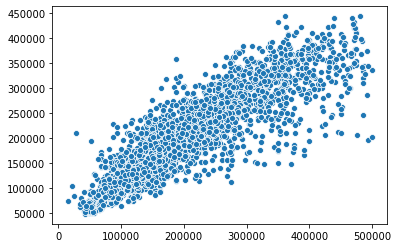

In [261]:
sns.scatterplot(y=y_pred, x=y_test);

In [262]:
importances = grid.best_estimator_['regress'].estimator.feature_importances_

In [275]:
extra_columns = ['rooms_per_household', 'bedrooms_per_room', 'pop_per_household']
selected_features = list(X_train.select_dtypes(np.number).columns.values) + extra_columns + ['INLAND', 'NEAR BAY', 'NEAR OCEAN']

In [276]:
imp = pd.DataFrame({'feature': selected_features, 'importance': importances})
imp = imp.sort_values(by='importance', ascending=False)

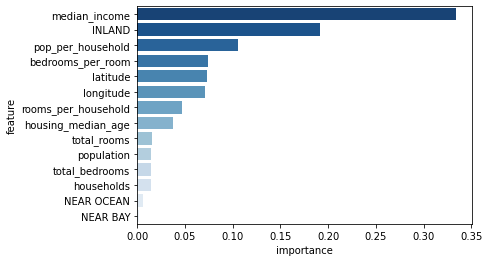

In [277]:
sns.barplot(x='importance', y='feature', data=imp, orient='h', palette='Blues_r');